# Forward Modeling of an Emission Spectrum using the hybrid (lpf+dit) Cross Section

In [1]:
from exojax.spec import rtransfer as rt
from exojax.spec import dit
from exojax.spec import lpf

In [2]:
#ATMOSPHERE                                                                     
NP=100
T0=1295.0 #K
Parr, dParr, k=rt.pressure_layer(NP=NP)
Tarr = T0*(Parr)**0.1

A T-P profile we assume is ...  

In [3]:
import matplotlib.pyplot as plt
plt.style.use('bmh')
plt.plot(Tarr,Parr)
plt.yscale("log")
plt.gca().invert_yaxis()
plt.show()

<Figure size 640x480 with 1 Axes>

We set a wavenumber grid using nugrid.

In [4]:
from exojax.spec.rtransfer import nugrid
nus,wav,res=nugrid(16450,16460,1000,unit="AA",xsmode="hybrid")

nugrid is linear: mode= hybrid


Loading a molecular database of CH4 and CIA (H2-H2)... 

In [5]:
from exojax.spec import moldb, contdb
mdbCH4=moldb.MdbExomol('.database/CH4/12C-1H4/YT10to10/',nus,crit=1.e-30)
cdbH2H2=contdb.CdbCIA('.database/H2-H2_2011.cia',nus)

Background atmosphere:  H2
Reading transition file
.broad is used.
Broadening code level= a1
default broadening parameters are used for  11  J lower states in  28  states
H2-H2


In [6]:
len(mdbCH4.A)

10654

In [7]:
from exojax.spec import molinfo
molmassCH4=molinfo.molmass("CH4")

Computing the relative partition function, 

In [8]:
from jax import vmap
qt=vmap(mdbCH4.qr_interp)(Tarr)

Pressure and Natural broadenings 

In [9]:
from jax import jit
from exojax.spec.exomol import gamma_exomol
from exojax.spec import gamma_natural

gammaLMP = jit(vmap(gamma_exomol,(0,0,None,None)))\
        (Parr,Tarr,mdbCH4.n_Texp,mdbCH4.alpha_ref)
gammaLMN=gamma_natural(mdbCH4.A)
gammaLM=gammaLMP+gammaLMN[None,:]

Doppler broadening

In [10]:
from exojax.spec import doppler_sigma
sigmaDM=jit(vmap(doppler_sigma,(None,0,None)))\
        (mdbCH4.nu_lines,Tarr,molmassCH4)

And line strength

In [11]:
from exojax.spec import SijT
SijM=jit(vmap(SijT,(0,None,None,None,0)))\
    (Tarr,mdbCH4.logsij0,mdbCH4.nu_lines,mdbCH4.elower,qt)

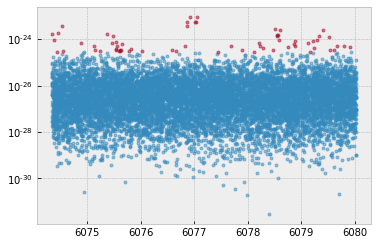

In [12]:
import jax.numpy as jnp
mask=SijM[-1,:]<jnp.max(SijM[-1,:])*3.e-2
plt.plot(mdbCH4.nu_lines[mask],SijM[-1,mask],".",label="DIT",alpha=0.5)
plt.plot(mdbCH4.nu_lines[~mask],SijM[-1,~mask],".",label="LPF",alpha=0.5)
plt.yscale("log")
plt.show()

In [13]:
print("# for DIT=",len(SijM[-1,mask]),", # for LPF=",len(SijM[-1,~mask]))

# for DIT= 10589 , # for LPF= 65


LPF 

In [14]:
from exojax.spec import make_numatrix0
numatrix=make_numatrix0(nus,mdbCH4.nu_lines[~mask])
xsmlpf=lpf.xsmatrix(numatrix,sigmaDM[:,~mask],gammaLM[:,~mask],SijM[:,~mask])

DIT

In [15]:
dgm_sigmaD=dit.dgmatrix(sigmaDM[:,mask],1.0)
dgm_gammaL=dit.dgmatrix(gammaLM[:,mask],1.0)

/home/kawahara/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


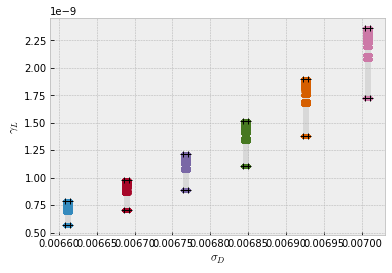

In [16]:
#show the DIT grids 
from exojax.plot.ditplot import plot_dgm
plot_dgm(dgm_sigmaD,dgm_gammaL,sigmaDM[:,mask],gammaLM[:,mask],0,6)

xsmatrix has the shape of (# of layers, # of nu grid)

In [18]:
from jax import jit
import numpy as np
# 3D version
xsmatrix3D=vmap(dit.xsvector3D,(None,0,0,0,None,0,0))
xsmdit=xsmatrix3D(mdbCH4.nu_lines[mask]-np.median(nus),sigmaDM[:,mask],gammaLM[:,mask],\
SijM[:,mask],nus-np.median(nus),dgm_sigmaD,dgm_gammaL)


In [19]:
len(mdbCH4.nu_lines[mask])

10589

In [20]:
xsm=xsmdit+xsmlpf

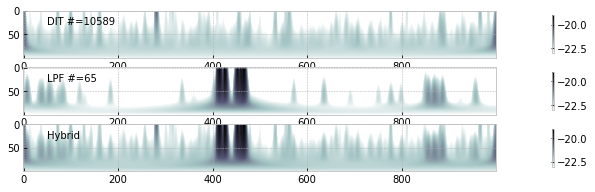

In [21]:
import numpy as np
fig=plt.figure(figsize=(20,4))
ax=fig.add_subplot(411)
c=plt.imshow(np.log10(xsmdit),cmap="bone_r",vmin=-23,vmax=-19)
plt.colorbar(c,shrink=0.8)
plt.text(50,30,"DIT #="+str(np.sum(mask)))
ax=fig.add_subplot(412)
c=plt.imshow(np.log10(xsmlpf),cmap="bone_r",vmin=-23,vmax=-19)
plt.colorbar(c,shrink=0.8)
plt.text(50,30,"LPF #="+str(np.sum(~mask)))
ax=fig.add_subplot(413)
c=plt.imshow(np.log10(xsm),cmap="bone_r",vmin=-23,vmax=-19)
plt.colorbar(c,shrink=0.8)
plt.text(50,30,"Hybrid")
plt.show()

computing delta tau for CH4

In [22]:
from exojax.spec.rtransfer import dtauM
Rp=0.88
Mp=33.2
g=2478.57730044555*Mp/Rp**2
#g=1.e5 #gravity cm/s2
MMR=0.0059 #mass mixing ratio
dtaum=dtauM(dParr,xsm,MMR*np.ones_like(Tarr),molmassCH4,g)

computing delta tau for CIA

In [23]:
from exojax.spec.rtransfer import dtauCIA
mmw=2.33 #mean molecular weight
mmrH2=0.74
molmassH2=molinfo.molmass("H2")
vmrH2=(mmrH2*mmw/molmassH2) #VMR
dtaucH2H2=dtauCIA(nus,Tarr,Parr,dParr,vmrH2,vmrH2,\
            mmw,g,cdbH2H2.nucia,cdbH2H2.tcia,cdbH2H2.logac)

The total delta tau is a summation of them

In [24]:
dtau=dtaum+dtaucH2H2

you can plot a contribution function using exojax.plot.atmplot 

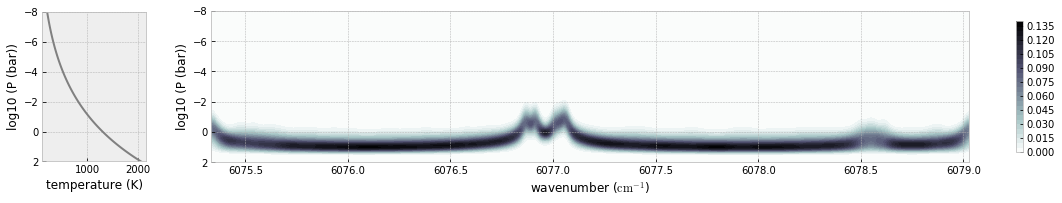

In [25]:
from exojax.plot.atmplot import plotcf
plotcf(nus,dtau,Tarr,Parr,dParr)
plt.show()

radiative transfering...

In [26]:
from exojax.spec import planck
from exojax.spec.rtransfer import rtrun
sourcef = planck.piBarr(Tarr,nus)
F0=rtrun(dtau,sourcef)

Text(0.5, 0, 'wavelength ($\\AA$)')

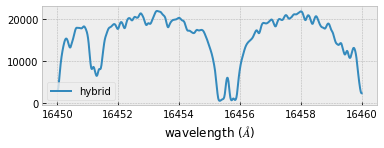

In [27]:
fig=plt.figure()
ax=fig.add_subplot(211)
plt.plot(wav[::-1],F0,label="hybrid")
plt.legend()
plt.xlabel("wavelength ($\AA$)")

To apply response, we need to convert the wavenumber grid from ESLIN to ESLOG. 

In [51]:
nuslog=np.logspace(np.log10(nus[0]),np.log10(nus[-1]),len(nus))
F0log=jnp.interp(nuslog,nus,F0)

applying an instrumental response and planet/stellar rotation to the raw spectrum

In [52]:
from exojax.spec import response
from exojax.utils.constants import c
import jax.numpy as jnp

wavd=jnp.linspace(22920,23000,500) #observational wavelength grid
nusd = 1.e8/wavd[::-1]

RV=10.0 #RV km/s
vsini=20.0 #Vsini km/s
u1=0.0 #limb darkening u1
u2=0.0 #limb darkening u2

R=100000.
beta=c/(2.0*np.sqrt(2.0*np.log(2.0))*R) #IP sigma need check 

Frot=response.rigidrot(nuslog,F0log,vsini,u1,u2)
F=response.ipgauss_sampling(nusd,nuslog,Frot,beta,RV)

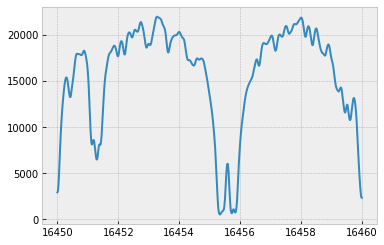

In [53]:
plt.plot(wav[::-1],F0)
plt.plot(wavd[::-1],F)